### AT&T  Detecteur de Spam

Nous allons devoir repérer, comprendre, analyser comment un modèle repère un spam ou non. Le but de ce projet est de créer des modèles de Deep Learning pour faire du preprocessing de Texte et comprendre les mechanismes derriere les spams. Nous allons classifier du text provenant de SMS pour detecter les spams en utilisant des modèles de machine learning supervisé. 

La target (spam ou non spam) est binaire donc nous sommes face devant un problème de classification binaire.

Nous tester différents modèles, allant de de modèles assez simple à modèles très complexes (transformers avec Bert) pour observer la différence entre les resultats. Nous pourrons aussi modifier le code interne des transformers pour faire du Fine tuning et ainsi se servir de leur entrainement sur de grandes quantités de données pour résoudre notre problèmatique de détection de spam

In [101]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [1]:
import pandas as pd
import numpy as np
import string
import spacy
import os
import string
import seaborn as sns

# import en_core_web_sm : au chois de l'utilisateur s'il préfère utiliser un nombre de vocabulaire small ou medium pour l'étude
import en_core_web_md
from spacy.lang.fr.stop_words import STOP_WORDS

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Le GPU est bien configuré avec Tensorflow (pour cela, nous avons utilisé CUDA (Compute Unified Device Architecture3) qui est une technologie de **GPGPU** (General-Purpose Computing on Graphics Processing Units), c'est-à-dire utilisant un processeur graphique (GPU) pour exécuter des calculs généraux à la place du processeur central (CPU)).

Nous avons utilisé CUDA Toolkit 12.0 qui nous permet de faire tourner notre carte graphique NVIDIA (il faut faire attention à l'installation des drivers qui doivent se faire manuellement.

L'avantage du GPU est qu'il peut augmenter x50 la vitesse de calcul qu'avec les CPU.

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
df = pd.read_csv("spam_jedha_project.csv", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Il y a très peu de variables et les 3 dernières ont l'air de ne pas servir (elles ne sont même pas correctement nommées). Faisons une brève analyse pour savoir si nous pouvons les retirer.

In [61]:
df.shape

(5572, 5)

In [62]:
print("colonne Unnamed_2 : ", df['Unnamed: 2'].value_counts().sum())
print("colonne Unnamed_3 : ", df['Unnamed: 3'].value_counts().sum())
print("colonne Unnamed_4 : ", df['Unnamed: 4'].value_counts().sum())

colonne Unnamed_2 :  50
colonne Unnamed_3 :  12
colonne Unnamed_4 :  6


Il y a quelques valeurs dans les 3 dernières colonnes mais elles sont trop peu nombreuses donc on va les supprimer

In [3]:
df = df.iloc[:, :2]

In [4]:
def test_null_values(df, print_=False, clean_nan=False):
    df_ = df.copy()
    for i, col in enumerate(df_.select_dtypes('object')):
        df_[col] = df_[col].apply(lambda x:np.nan if x=='' else x)
    if print_:
        print(df_.isna().sum()) 
    index_ = df_[pd.isnull(df_).any(1)].index
    if clean_nan:
        mask_nan = df_.index.isin(index_)
        df_ = df_[~mask_nan]
        df_ = df_.reset_index().drop(['index'], axis=1)
    return df_

In [5]:
test_null_values(df, print_=True, clean_nan=True)

v1    0
v2    0
dtype: int64


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Il n'y a aucune valeurs manquantes dans les 2 colonnes : on va les renommer pour plus de clarté

In [6]:
df.columns = ['target', 'message']

Nous allons egalement mapper les strings 'ham' et 'spam' en valeur binaire (cela evitera de faire un LabelBinarizer() au moment du `train_test_split`)

In [7]:
df['is_spam'] = df.target.apply(lambda x: 1 if x=='spam' else 0)

In [8]:
df['is_spam'].value_counts()

0    4825
1     747
Name: is_spam, dtype: int64

Comme nous sommes face à un dataset déséquilibré, nous essaierons dans un autre notebook SMOTE pour rééquilibrer les classes.

Passons rapidement à une EDA pour oberver quelques statistiques sur ce dataset.

### EDA

Analysons la longeur des messages pour savoir si c'est un élement important dans la detection des spams

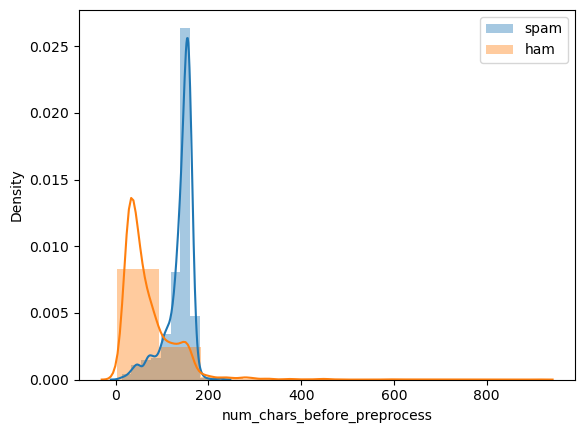

In [9]:
df['num_chars_before_preprocess'] = df['message'].apply(len)

df_spam = df[df['target']=='spam']
df_ham = df[df['target']=='ham']


plt.figure()
sns.distplot(df_spam['num_chars_before_preprocess'], label='spam', bins=10)
sns.distplot(df_ham['num_chars_before_preprocess'], label='ham',bins=10)
plt.legend()

On observe bien une différence entre les `spam` et les `ham`. Regardons plus en détails ces informations.

In [87]:
def display_len_information(df, col, spam_or_ham, char=False):
    temp='mots'
    if char:temp='caractères'
    print(f"longueur minimal de {temp} d'un message {spam_or_ham} : {int(df[col].min())}")
    print(f"longueur maximal de {temp} d'un message {spam_or_ham} : {int(df[col].max())}")
    print(f"longueur moyenne de {temp} d'un message {spam_or_ham} : {int(df[col].mean())}")
    print(f"ecart type longueur de {temp} message {spam_or_ham}   : {int(df[col].std())}")
    print(f"longueur 25% de {temp} d'un message {spam_or_ham}     : {int(np.quantile(df[col], 0.25))}")
    print(f"longueur motiée de {temp} d'un message {spam_or_ham}  : {int(np.quantile(df[col], 0.50))}")
    print(f"longueur 75% de {temp} d'un message {spam_or_ham}     : {int(np.quantile(df[col], 0.75))}")

#### Spam

In [88]:
display_len_information(df_spam, col='num_chars_before_preprocess', spam_or_ham='spam', char=True)

longueur minimal de caractères d'un message spam : 13
longueur maximal de caractères d'un message spam : 224
longueur moyenne de caractères d'un message spam : 138
ecart type longueur de caractères message spam   : 29
longueur 25% de caractères d'un message spam     : 132
longueur motiée de caractères d'un message spam  : 149
longueur 75% de caractères d'un message spam     : 157


#### Ham

In [89]:
display_len_information(df_ham, col='num_chars_before_preprocess', spam_or_ham='ham', char=True)

longueur minimal de caractères d'un message ham : 2
longueur maximal de caractères d'un message ham : 910
longueur moyenne de caractères d'un message ham : 71
ecart type longueur de caractères message ham   : 58
longueur 25% de caractères d'un message ham     : 33
longueur motiée de caractères d'un message ham  : 52
longueur 75% de caractères d'un message ham     : 92


In [73]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=df_ham['num_chars_before_preprocess'],
    name="Ham",
    jitter=0.3,
    pointpos=-1.8,
    boxpoints='all', # represent all points
    marker_color='rgb(8,81,156)',
    line_color='rgb(8,81,156)'
))

fig.add_trace(go.Box(
    y=df_spam['num_chars_before_preprocess'],
    name="Spam",
    boxpoints='all', # only outliers
    marker_color='rgb(107,174,214)',
    line_color='rgb(107,174,214)'
))


fig.show()

On remarque plusieurs phénomènes :
    
D'abord, nous voyons que les messages qui sont des spams contiennent en moyenne plus de caractères. De plus, on observe une homogénité ddans le nombre de caractères d'un message spam.

Il y a quelques outliers en ham mais nous allons les garder pour l'instant (nous deciderons plus tard si nous devons les enlever, je ne pense pas que ca pose problème car les outliers sont de très grandes valeurs et ces valeurs appartiennent à la ditribution de Ham qui contient plus de caractères dans les message que Spam

Nous allons créer également 2 colonnes supplémentaires qui, cette fois ci, montre le nombre de mots par message (et non pas le nombre de caractères totaux) ainsi que le nombre moyen de caractères par mots.

In [10]:
df['len_message_before_preprocess'] = df['message'].apply(lambda x: len(x.split()))
df['len_word'] = df['num_chars_before_preprocess'] // df['len_message_before_preprocess']

In [11]:
df = df[df["message"].apply(lambda x: isinstance(x, str))]

In [12]:
df

,target,message,is_spam,num_chars_before_preprocess,len_message_before_preprocess,len_word
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,20,5
1,ham,Ok lar... Joking wif u oni...,0,29,6,4
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,5
3,ham,U dun say so early hor... U c already then say...,0,49,11,4
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,13,4
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,30,5
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,8,4
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,10,5
5570,ham,The guy did some bitching but I acted like i'd...,0,125,26,4


In [13]:
df_spam = df[df['is_spam'] == 1]
df_ham = df[df['is_spam'] == 0]

In [92]:
display_len_information(df_spam, col='len_message_before_preprocess', spam_or_ham='spam')

longueur minimal de mots d'un message spam : 2
longueur maximal de mots d'un message spam : 35
longueur moyenne de mots d'un message spam : 23
ecart type longueur de mots message spam   : 5
longueur 25% de mots d'un message spam     : 22
longueur motiée de mots d'un message spam  : 25
longueur 75% de mots d'un message spam     : 28


In [93]:
display_len_information(df_ham, col='len_message_before_preprocess', spam_or_ham='ham')

longueur minimal de mots d'un message ham : 1
longueur maximal de mots d'un message ham : 171
longueur moyenne de mots d'un message ham : 14
ecart type longueur de mots message ham   : 11
longueur 25% de mots d'un message ham     : 7
longueur motiée de mots d'un message ham  : 11
longueur 75% de mots d'un message ham     : 19


In [96]:
print("---------------------------------------------SPAM---------------------------------------------")
print("moyenne du nombre de caractères (spam):", int(df_spam['num_chars_before_preprocess'].mean()))
print("moyenne du nombre de mots (spam)      :", int(df_spam['len_message_before_preprocess'].mean()))
print("moyenne de longueur d'un mot(spam)    :", int(df_spam['len_word'].mean()), '\n')

print("---------------------------------------------HAM---------------------------------------------")
print("moyenne du nombre de caractères (ham) :", int(df_ham['num_chars_before_preprocess'].mean()))
print("moyenne du nombre de mots (ham)       :", int(df_ham['len_message_before_preprocess'].mean()))
print("moyenne de longueur d'un mot(ham)     :", int(df_ham['len_word'].mean()))

---------------------------------------------SPAM---------------------------------------------
moyenne du nombre de caractères (spam): 138
moyenne du nombre de mots (spam)      : 23
moyenne de longueur d'un mot(spam)    : 5 

---------------------------------------------HAM---------------------------------------------
moyenne du nombre de caractères (ham) : 71
moyenne du nombre de mots (ham)       : 14
moyenne de longueur d'un mot(ham)     : 4


On voit que les SMS qui sont des `spams` contiennent **plus de caractères et de mots**.

### Data Viz

Cette fois-ci nous nous focalisons sur le nombre de mots par message

In [97]:
fig = px.pie(df, names='is_spam')
fig.show()

In [106]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_spam["len_message_before_preprocess"], histnorm='probability density'))
fig.add_vline(x=df_spam["len_message_before_preprocess"].mean(), line_width=3, line_dash="dash", line_color="blue")
fig.add_trace(go.Histogram(x=df_ham["len_message_before_preprocess"], histnorm='probability density'))
fig.add_vline(x=df_ham["len_message_before_preprocess"].mean(), line_width=3, line_dash="dash", line_color="red")
fig.update_layout(barmode='overlay')
fig.show()

Nous remarquons la même différence de distributions entre les spams et les hams : les spams représentent plus de mots que les hams

In [99]:
fig = px.histogram(df, x="is_spam", y=df['message'].apply(lambda x: len(x.split('..'))), color="is_spam")
fig.show()

Nous sommes bien devant deux classes très déséquilibrées avec une très grande majorité de non spam(donc de ham)

In [100]:
fig = px.box(df, x="is_spam", y="len_message_before_preprocess", points="all", color='is_spam')
fig.show()

Pareil que pour les caractères, nous nous retrouvons encore une fois face à une meilleur homogénité des spams (comme si tous les spams se ressemblent en longueur de caractères et de mots) et avec quelques outliers que nous decidons de laisser

Nous allons passer au preprocessing de texte pour le vectoriser, cad convertir des données de chaines de caractères en données numériques.

## Text Preprocessing

Une question se pose quand a la façon de proceder au preprocessing : Doit stemmatiser ou lemmatiser les messages ? quelles ponctuations garder ? Nous pourrions faire beaucoup d'essais mais il faut rester pragmatique et commencer à réaliser des taches simples et ensuite en essayer des plus complexes car il faut suivre un déroulement logique pour arriver à de bons résultats.

D'abord, nous avons le choix entre lemmatiser, stemmatizer ou ne rien faire..nous allons plus tard décider d'une methode et si tenir (nous changerons si nous nous sommes trompés et que nous obtenons de mauvais résultats).

On va choisir de lemmatiser car cela garde mieux le contexte que la stemmatization : le fait de retirer seulement le diminutif (la fin des mots qui se ressemblent avec les stems) nous fait perdre cette subtilités de savoir si c'est un homme,une femme, certains verbes qui ne ressortiront pas bien, ainsi que d'autres details nous laissent croire à une plus grande efficacité envers la lemmatization.

On importe le vocabulaire de taille "medium" grace à Spacy et nous allons pouvoir lemmatizer.

In [14]:
nlp = en_core_web_md.load()

### Lemmatization

In [15]:
# Supprime tous les caractères non alphanumerique exceptés les whitespaces
df["message_clean"] = df["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))

# Supprime les doubles spaces et spaces au début et la fin des strings
df["message_clean"] = df["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# Supprime les stop-words et remplace chaque mot par leur version lematiser
df["message_clean"] = df["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [16]:
df

,target,message,is_spam,num_chars_before_preprocess,len_message_before_preprocess,len_word,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,20,5,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,29,6,4,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,28,5,free entry in 2 wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,0,49,11,4,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,13,4,nah do not think he go to usf he live around h...
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,30,5,this be the 2nd time we have try 2 contact u u...
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,8,4,will ì b go to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,10,5,pity be in mood for that soany other suggestion
5570,ham,The guy did some bitching but I acted like i'd...,0,125,26,4,the guy do some bitching but act like d be int...


In [29]:
# df.to_csv('lemat_df.csv', index=False)
df = pd.read_csv('lemat_df.csv')

In [17]:
df['message_clean'] = df['message_clean'].astype(str)

### Tokenization pour Model 1

In [18]:
X = df["message_clean"]
y = df['target']

In [19]:
max_words = 1000
max_len = 200

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_encoded = tokenizer.texts_to_sequences(X)

sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len)

In [20]:
df_encoded = pd.concat([pd.Series(X_encoded), df['is_spam']], axis=1)
df_encoded = df_encoded.rename(columns={0:'message_encoded', 'is_spam':'target'})
df_encoded

,message_encoded,target
0,"[19, 405, 338, 575, 596, 64, 9, 89, 109, 307, ...",0
1,"[46, 294, 597, 406, 6]",0
2,"[49, 421, 9, 22, 669, 803, 2, 86, 995, 549, 25...",1
3,"[6, 221, 60, 24, 249, 6, 154, 137, 56, 60]",0
4,"[847, 7, 5, 68, 35, 19, 2, 804, 35, 227, 199, ...",0
...,...,...
5567,"[34, 1, 4, 376, 57, 27, 10, 110, 22, 165, 6, 6...",1
5568,"[25, 101, 190, 19, 2, 713, 78]",0
5569,"[1, 9, 12, 18, 195]",0
5570,"[4, 204, 7, 103, 26, 52, 85, 1, 9, 158, 180, 4...",0


### Resampling

Nous ne pourrons pas utiliser SMOTE (ou SMOTE-NC pour les variables Numeriques-Catégorielle) car nous n'avons pas assez de variables.

Bien que notre approche SMOTE ne gère pas actuellement les datasets avec toutes les features nominales, elle a été généralisée pour gérer des ensembles de données mixtes de features continues et nominales. Nous appelons cette approche Synthetic Minority Over-sampling TEchnique-Nominal Continuous [SMOTE-NC]

1. **Calcul de la médiane** : calculez la médiane des écarts-types de toutes les caractéristiques continues pour la classe minoritaire. Si les caractéristiques nominales diffèrent entre un échantillon et ses voisins les plus proches potentiels, cette médiane est incluse dans le calcul de la distance euclidienne. Nous utilisons la médiane pour pénaliser la différence des caractéristiques nominales d'un montant qui est lié à la différence typique des valeurs des caractéristiques continues. 

2. **Calcul du voisin le plus proche(knn)** : calculez la distance euclidienne entre le vecteur de caractéristiques pour lequel les k plus proches voisins sont identifiés (échantillon de classe minoritaire) et les autres vecteurs de caractéristiques (échantillons de classe minoritaire) à l'aide de l'espace de caractéristiques continu. Pour chaque caractéristique nominale différente entre le vecteur de caractéristique considéré et son plus proche voisin potentiel, inclure la médiane des écarts-types précédemment calculés, dans le calcul de la distance euclidienne. 

Ainsi, il est évident que, pour que l'algorithme fonctionne, il a besoin d'au moins une caractéristique continue. Ce n'est pas le cas ici, donc l'algorithme échoue sans surprise lors de l'étape 1 (calcul médian), car il n'y a pas de caractéristiques continues à utiliser pour le calcul médian.

Nous allons donc devoir trouver d'autres techniques

### Undersampling

Comme nous nous retrouvons dans une situation ou ne pouvons utiliser SMOTE, nous allons essayer de faire de l'undersampling pour essayer d'équilibrer les classes `ham` et `spam`. Nous allons garder une partie de notre dataset pour l'evaluation finale avant de procéder au réechantillonnage.

On va créer une fonction qui permet d'enlever des echantillons de la classe majoritaire pour rééquilibrer la classe minoritaire. Nous avons, de base, 4825 samples représentant les `hams` et seulement 747 pour les `spams` : cela fait un rapport de 1 pour 6.45, cad qu'il y a 2 `spams` pour 13 `hams`. Logiquement, nous allons donc tester pour la valeur 6 (en arrondissant), on va donc devoir abaisser de 6 fois le nombre de `hams` dans notre dataset. Pour cela, nous allons multiplier le nombre de `spams` total par 6 pour prendre de 1 à 6 * len(`spams`) selon nos envies. Il faut savoir que 1 correspond à prendre 747 samples pour chaque classe et 6.45 correspond à prendre le dataset initial déséquilibré. Nous allons donc faire un compromis et prendre une valeur de 3.2 fois `hams` la quantité de `spams`. Nous testerons par la suite différentes valeurs et nous comparerons les résultats (En data science, nous sommes souvent obligé d'avancer à l'aveugle, cad de tester pleins de possibilités et de ne retenir que celle qui donne les meilleurs resultats).

Nous retenons donc la valeur de 3.2 puis nous aviserons en fonction des résultats obtenus


In [91]:
def preprocess_undersampling(X, shuffle=True, test_size=0.2, stratify=True, seed=None, operator=1):
    """ Split les data en test et val """
    if shuffle:
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        X = X.iloc[idx, :]
    # Split en fonction du test_size
    split_i = len(X) - int(len(X) // int(1 / test_size))
    train = X[:split_i] 
    val = X[split_i:]
    
    sample1 = train.loc[train['target']== 1,:]
    sample0 = train.loc[train['target']== 0,:].sample(int(operator * len(sample1)))
    df = pd.concat([sample0,sample1], axis=0).reset_index(drop=True)
  
    return df, val


In [92]:
undersampling, validation_set = preprocess_undersampling(df_encoded, test_size=0.2, stratify=True, seed=None, operator=3.2)
undersampling['target'].value_counts()

0    1923
1     601
Name: target, dtype: int64

In [93]:
max_len = len(max(df['message_clean'], key=len).split())
max_len

164

In [94]:
def final_process(df_train, df_val):
    padding_train = tf.keras.preprocessing.sequence.pad_sequences(df_train['message_encoded'], padding="post", maxlen=max_len)
    padding_valid = tf.keras.preprocessing.sequence.pad_sequences(df_val['message_encoded'], padding="post", maxlen=max_len)
    return padding_train, padding_valid

In [95]:
padding_train, padding_val = final_process(undersampling, validation_set)

### Train test split

In [ ]:
Nous allons devoir creer plusieurs dataframes

In [111]:
X = df["message_clean"]
y = df['target']

le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1, 1)

In [112]:
X.shape, y.shape

((5572,), (5572, 1))

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [114]:
X_train

4128                            m not workin once get job
134     want 2 get lay tonight want real dogging locat...
2360    have the money issue weigh down but thank to y...
3545    so be th gower mate which be where be how r u ...
3253                       can make lasagna for you vodka
                              ...                        
2580    u be subscribe to the good mobile content serv...
5187                                    what time u wrkin
4344                                     enjoy urself tmr
3697               sbut he have some luck2 catch put down
3389    please call 08712402972 immediately there be a...
Name: message_clean, Length: 4457, dtype: object

### Tokenization pour Model 1

In [115]:
len(max(df['message_clean'], key=len).split())

164

In [116]:
max_words = 2000
max_len = 200

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="out_of_vocab")
tokenizer.fit_on_texts(X_train)
X_encoded = tokenizer.texts_to_sequences(X_train)

sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=max_len)

### Resampling

In [122]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [119]:
def data_under_sampling(data, nb_reduce):
    data_sample_2 = data.loc[data['v1']=='spam',:]
    len_class_sub = len(data_sample_2)
    data_sample_1 = data.loc[data['v1']=='ham',:].sample(nb_reduce * len_class_sub)
  
    return pd.concat([data_sample_1,data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)

In [120]:
resampling = data_under_sampling(df, 4)

KeyError: 'v1'

### Model 1 

Model simple LSTM

In [45]:
model = tf.keras.Sequential([
    keras.layers.Embedding(max_words, 32, input_length=max_len),
    keras.layers.LSTM(64),
    keras.layers.Flatten(),
    keras.layers.Dense(250, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           32000     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 250)               16250     
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30120     
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [61]:
history = model.fit(sequences_padded,
          y_train,
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
28/28 [==============================] - 1s 23ms/step - loss: 0.0582 - accuracy: 0.9815 - val_loss: 0.0660 - val_accuracy: 0.9787
Epoch 2/10
28/28 [==============================] - 0s 17ms/step - loss: 0.0428 - accuracy: 0.9865 - val_loss: 0.0631 - val_accuracy: 0.9798


[tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) : Stop l'entrainement lorsqu'il n'y a plus d'amélioration de la metric 'monitor'

In [49]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)

In [50]:
scores = model.evaluate(test_sequences_padded, y_test, verbose=0)
scores

[0.054718323051929474, 0.9883407950401306]

In [51]:
print("Accuracy : %2f%%" %(scores[1]*100))

Accuracy : 98.834080%


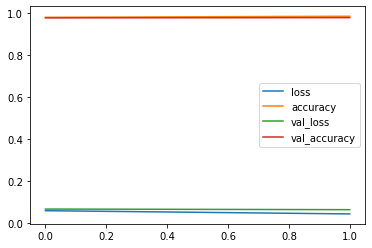

In [62]:
pd.DataFrame(history.history).plot();

### Model 2 

Avec une layer de TextVectorization

In [76]:
max_words = 1000
max_len = 200

text_vectorized = tf.keras.layers.TextVectorization(
    max_tokens=max_words,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=max_len
)

text_vectorized.adapt(X_train)

In [77]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=max_words,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=max_len
)

In [78]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vector_layer = text_vectorized(input_layer)
embedding_layer_model = embedding_layer(vector_layer)

x = tf.keras.layers.GlobalAveragePooling1D()
x = x(embedding_layer_model)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = keras.Model(input_layer, output_layer)

In [82]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 200, 128)          128000    
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128

In [79]:
model_2.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
                metrics=['accuracy'])

In [80]:
history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2 * len(X_test)))

Epoch 1/10
140/140 [==============================] - 2s 14ms/step - loss: 0.6303 - accuracy: 0.8544 - val_loss: 0.6186 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 2s 12ms/step - loss: 0.6141 - accuracy: 0.8658 - val_loss: 0.6050 - val_accuracy: 0.8664
Epoch 3/10
140/140 [==============================] - 2s 12ms/step - loss: 0.5915 - accuracy: 0.9174 - val_loss: 0.5873 - val_accuracy: 0.9677
Epoch 4/10
140/140 [==============================] - 2s 11ms/step - loss: 0.5792 - accuracy: 0.9697 - val_loss: 0.5772 - val_accuracy: 0.9704
Epoch 5/10
140/140 [==============================] - 2s 12ms/step - loss: 0.5750 - accuracy: 0.9771 - val_loss: 0.5753 - val_accuracy: 0.9776
Epoch 6/10
140/140 [==============================] - 2s 11ms/step - loss: 0.5731 - accuracy: 0.9812 - val_loss: 0.5737 - val_accuracy: 0.9821
Epoch 7/10
140/140 [==============================] - 2s 12ms/step - loss: 0.5724 - accuracy: 0.9823 - val_loss: 0.5722 - val_accuracy: 0.9821

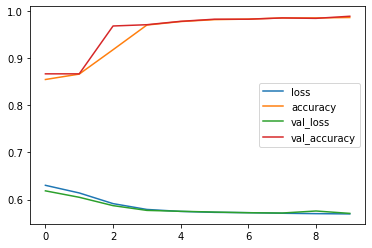

In [81]:
pd.DataFrame(history_2.history).plot();

### Model 3

Bi-LSTM Model

In [86]:
input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.string) 

vector_layer = text_vectorized(input_layer) 
embedding_layer_model = embedding_layer(vector_layer) 

bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True))(embedding_layer_model) 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(bi_lstm)

flatten = tf.keras.layers.Flatten()(lstm) 

dropout = tf.keras.layers.Dropout(.2)(flatten) 

x = tf.keras.layers.Dense(32, activation='relu')(dropout) 

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x) 

In [87]:
model_3 = tf.keras.Model(input_layer, output_layer) 

In [88]:
model_3.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
                metrics=['accuracy'])

In [90]:
history_3 = model_3.fit(X_train,
                        y_train,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))

Epoch 1/10
140/140 [==============================] - 15s 74ms/step - loss: 0.5711 - accuracy: 0.9868 - val_loss: 0.5678 - val_accuracy: 0.9883
Epoch 2/10
140/140 [==============================] - 9s 65ms/step - loss: 0.5667 - accuracy: 0.9904 - val_loss: 0.5742 - val_accuracy: 0.9740
Epoch 3/10
140/140 [==============================] - 9s 65ms/step - loss: 0.5660 - accuracy: 0.9933 - val_loss: 0.5713 - val_accuracy: 0.9812
Epoch 4/10
140/140 [==============================] - 9s 66ms/step - loss: 0.5655 - accuracy: 0.9935 - val_loss: 0.5697 - val_accuracy: 0.9830
Epoch 5/10
140/140 [==============================] - 9s 66ms/step - loss: 0.5653 - accuracy: 0.9944 - val_loss: 0.5675 - val_accuracy: 0.9910
Epoch 6/10
140/140 [==============================] - 9s 64ms/step - loss: 0.5643 - accuracy: 0.9966 - val_loss: 0.5683 - val_accuracy: 0.9874
Epoch 7/10
140/140 [==============================] - 9s 66ms/step - loss: 0.5643 - accuracy: 0.9964 - val_loss: 0.5706 - val_accuracy: 0.983

In [94]:
y_preds = np.round(model_3.predict(X_test))
accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)

35/35 [==============================] - 1s 22ms/step


In [97]:
print('accuracy  : ',accuracy)
print('precision : ',precision)
print('recall    : ',recall)
print('f1-score  : ',f1)

accuracy  :  0.9883408071748879
precision :  0.9473684210526315
recall    :  0.9664429530201343
f1-score  :  0.9568106312292358


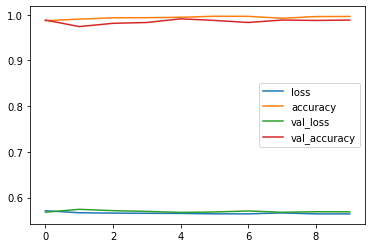

In [98]:
pd.DataFrame(history_3.history).plot();